# Phase A: Exploration et Analyse des Données

## Objectifs
- Charger les datasets (Business, User, Review)
- Nettoyer et fusionner les données
- Analyser les distributions (Catégories, Notes, etc.)
- Analyser les corrélations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Configuration
# Note: Structure is Data/filename/filename (nested folders)
DATA_DIR = "../Data"
pd.set_option('display.max_columns', None)

# Chargement des données
print("Loading Business data...")
business_df = pd.read_json(
    os.path.join(DATA_DIR, "yelp_academic_dataset_business.json", "yelp_academic_dataset_business.json"),
    lines=True
)
print(f"Business shape: {business_df.shape}")

print("Loading User data...")
user_df = pd.read_json(
    os.path.join(DATA_DIR, "yelp_academic_dataset_user4students.jsonl", "yelp_academic_dataset_user4students.jsonl"),
    lines=True
)
print(f"User shape: {user_df.shape}")

print("Loading Review data (this might take a while)...")
review_df = pd.read_json(
    os.path.join(DATA_DIR, "yelp_academic_reviews4students.jsonl", "yelp_academic_reviews4students.jsonl"),
    lines=True
)
print(f"Review shape: {review_df.shape}")

Loading Business data...
Business shape: (150346, 14)
Loading User data...
User shape: (558095, 22)
Loading Review data (this might take a while)...
Review shape: (1000000, 9)


In [3]:
business_df.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [4]:
review_df.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
1,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14
2,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48


## 1. Fusion des données

In [5]:
# Fusion Review + Business (pour avoir la catégorie et infos business)
df = review_df.merge(business_df, on="business_id", how="left", suffixes=("_review", "_biz"))

# Fusion + User (pour avoir les infos user)
df = df.merge(user_df, on="user_id", how="left", suffixes=("", "_user"))

print(f"Fused dataset shape: {df.shape}")
df.head(2)

Fused dataset shape: (1000000, 43)


,review_id,user_id,business_id,stars_review,useful,funny,cool,text,date,name,address,city,state,postal_code,latitude,longitude,stars_biz,review_count,is_open,attributes,categories,hours,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53,Bru Burger Bar - Indianapolis,410 Massachusetts Ave,Indianapolis,IN,46204,39.773307,-86.152091,4.0,1608,1,"{'BikeParking': 'True', 'GoodForKids': 'True',...","Restaurants, Gluten-Free, Bars, Food, Nightlif...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",Dev,41.0,2017-11-11 05:55:29,24.0,4.0,18.0,2021,"X0BSdbAfXOfi5hzAbPmBKg, 6shiT2w2lQLqbmFEif5xCg...",1.0,3.72,1.0,0.0,0.0,0.0,0.0,7.0,1.0,6.0,6.0,1.0,1.0
1,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14,Firestone Complete Auto Care,424 Lapalco Blvd,Gretna,LA,70056,29.880530,-90.029300,3.5,19,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Auto Repair, Auto Parts & Supplies, Tires, Aut...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-19:0', '...",Kyle,5.0,2014-01-25 22:13:53,2.0,0.0,0.0,,"4TcXNjMbXdTEKeBbGbzNxQ, aIiA8ajHdXrEYgyhBPF5EQ",0.0,4.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Analyse des catégories de Business

C:\Users\anas\AppData\Local\Temp\ipykernel_17196\3865149662.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


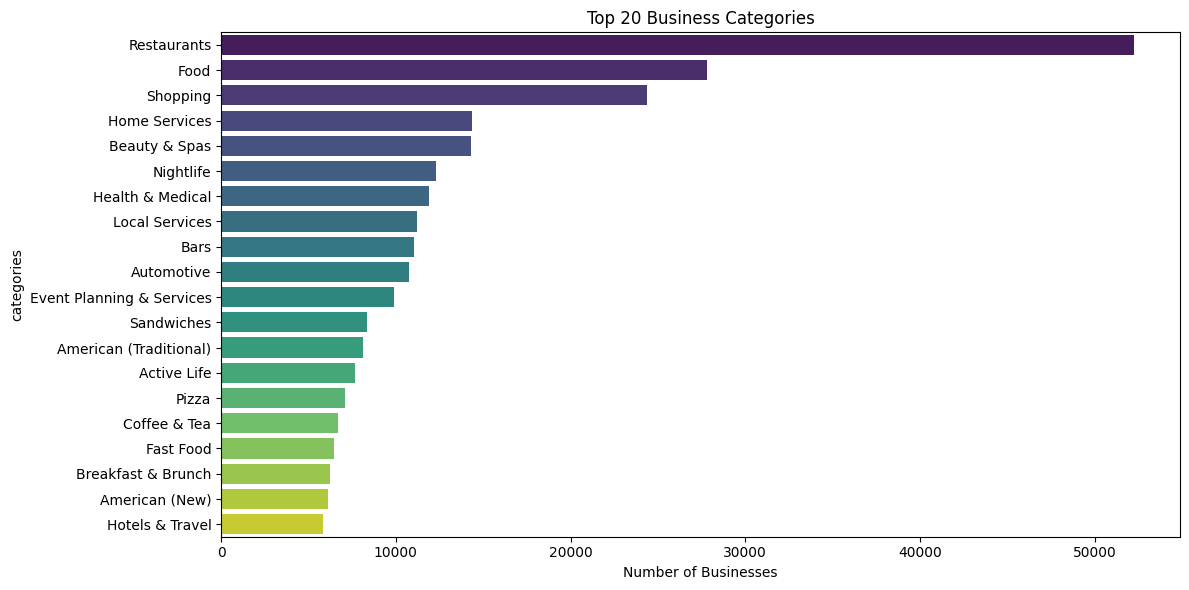

In [6]:
# Explosion des catégories (car format "Cat1, Cat2, ...")
categories_expanded = business_df.assign(categories=business_df['categories'].str.split(', ')).explode('categories')
top_categories = categories_expanded['categories'].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title("Top 20 Business Categories")
plt.xlabel("Number of Businesses")
plt.tight_layout()
plt.savefig("../references/fig_categories.png", dpi=150)
plt.show()

## 3. Corrélation : Nombre d'avis vs Note Moyenne

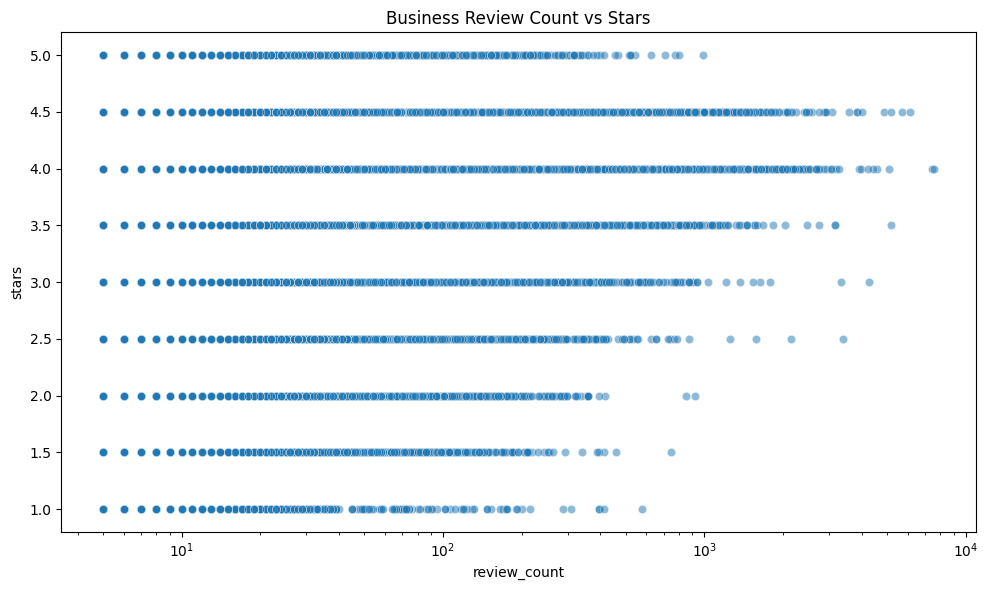

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=business_df, x="review_count", y="stars", alpha=0.5)
plt.title("Business Review Count vs Stars")
plt.xscale('log')
plt.tight_layout()
plt.savefig("../references/fig_reviews_vs_stars.png", dpi=150)
plt.show()

## 4. Analyse de la sévérité des "Big Reviewers"

Average rating given by reviewers:
is_big_reviewer
False    3.667107
True     3.821339
Name: avg_stars_given, dtype: float64


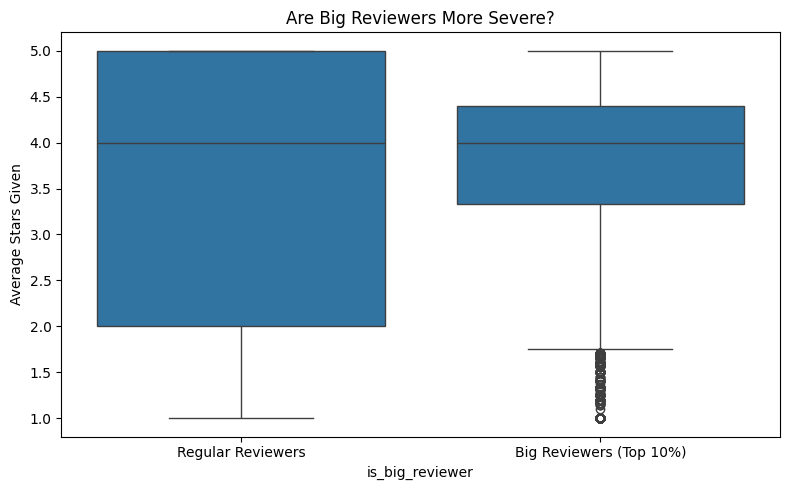

In [8]:
# Calculer la note moyenne donnée par chaque utilisateur
user_avg_rating = review_df.groupby('user_id')['stars'].agg(['mean', 'count']).reset_index()
user_avg_rating.columns = ['user_id', 'avg_stars_given', 'review_count']

# Big reviewers = top 10% par nombre d'avis
threshold = user_avg_rating['review_count'].quantile(0.90)
user_avg_rating['is_big_reviewer'] = user_avg_rating['review_count'] >= threshold

# Comparaison
comparison = user_avg_rating.groupby('is_big_reviewer')['avg_stars_given'].mean()
print("Average rating given by reviewers:")
print(comparison)

plt.figure(figsize=(8, 5))
sns.boxplot(data=user_avg_rating, x='is_big_reviewer', y='avg_stars_given')
plt.xticks([0, 1], ['Regular Reviewers', 'Big Reviewers (Top 10%)'])
plt.title("Are Big Reviewers More Severe?")
plt.ylabel("Average Stars Given")
plt.tight_layout()
plt.savefig("../references/fig_big_reviewers.png", dpi=150)
plt.show()

## 5. Longueur des reviews vs Note

Average review length by stars:
stars
1    713.219030
2    726.506557
3    668.441386
4    588.448649
5    462.938865
Name: text_length, dtype: float64


C:\Users\anas\AppData\Local\Temp\ipykernel_17196\1123743336.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=length_by_stars.index, y=length_by_stars.values, palette="coolwarm")


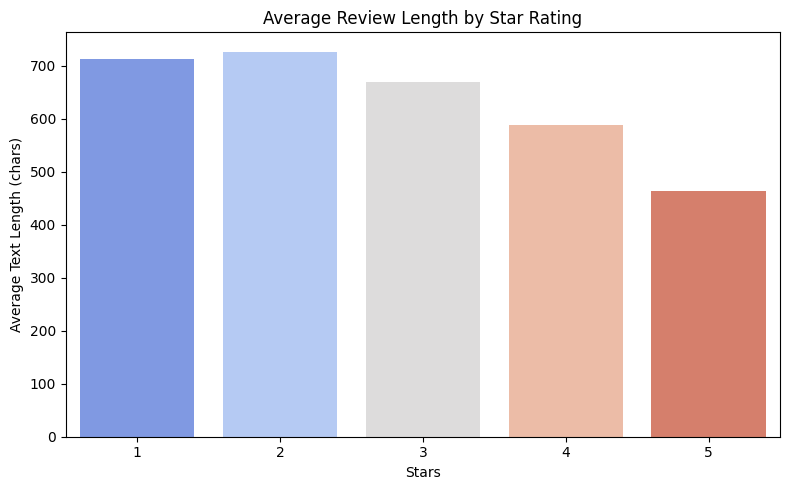

In [9]:
# Ajouter longueur du texte
review_df['text_length'] = review_df['text'].str.len()

# Moyenne par classe de note
length_by_stars = review_df.groupby('stars')['text_length'].mean()
print("Average review length by stars:")
print(length_by_stars)

plt.figure(figsize=(8, 5))
sns.barplot(x=length_by_stars.index, y=length_by_stars.values, palette="coolwarm")
plt.title("Average Review Length by Star Rating")
plt.xlabel("Stars")
plt.ylabel("Average Text Length (chars)")
plt.tight_layout()
plt.savefig("../references/fig_length_vs_stars.png", dpi=150)
plt.show()

## 6. Vocabulaire TF-IDF : Positifs vs Négatifs

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sous-échantillon pour la rapidité
sample_size = 10000
positive_reviews = review_df[review_df['stars'] >= 4]['text'].sample(min(sample_size, len(review_df[review_df['stars'] >= 4])), random_state=42)
negative_reviews = review_df[review_df['stars'] <= 2]['text'].sample(min(sample_size, len(review_df[review_df['stars'] <= 2])), random_state=42)

def get_top_tfidf_words(texts, n=10):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-n:][::-1]
    return [(feature_names[i], mean_tfidf[i]) for i in top_indices]

print("Top 10 TF-IDF words in POSITIVE reviews:")
top_positive = get_top_tfidf_words(positive_reviews)
for word, score in top_positive:
    print(f"  {word}: {score:.4f}")

print("\nTop 10 TF-IDF words in NEGATIVE reviews:")
top_negative = get_top_tfidf_words(negative_reviews)
for word, score in top_negative:
    print(f"  {word}: {score:.4f}")

Top 10 TF-IDF words in POSITIVE reviews:
  great: 0.0515
  food: 0.0438
  good: 0.0415
  place: 0.0400
  service: 0.0330
  time: 0.0273
  best: 0.0273
  amazing: 0.0243
  love: 0.0240
  like: 0.0236

Top 10 TF-IDF words in NEGATIVE reviews:
  food: 0.0437
  service: 0.0347
  place: 0.0345
  just: 0.0322
  time: 0.0305
  like: 0.0300
  good: 0.0278
  order: 0.0265
  don: 0.0242
  got: 0.0224


## 7. Préparation des labels pour la classification

In [14]:
# Créer les labels de polarité
def get_polarity(stars):
    if stars > 3:
        return 'positive'
    elif stars < 3:
        return 'negative'
    else:
        return 'neutral'

review_df['polarity'] = review_df['stars'].apply(get_polarity)

print("Polarity distribution:")
print(review_df['polarity'].value_counts())

# Sauvegarder un dataset préparé pour la Phase B
prepared_df = review_df[['text', 'stars', 'polarity', 'text_length']].copy()
prepared_df.to_parquet("../Data/prepared_reviews.parquet", index=False)
print("\nSaved prepared dataset to ../Data/prepared_reviews.parquet")

Polarity distribution:
polarity
positive    670599
negative    230687
neutral      98714
Name: count, dtype: int64


ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - `Import pyarrow` failed. pyarrow is required for parquet support. Use pip or conda to install the pyarrow package.
 - `Import fastparquet` failed. fastparquet is required for parquet support. Use pip or conda to install the fastparquet package.